In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [3]:
import warnings 
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
df['CustomerId'].nunique()

10000

In [7]:
df['Surname'].nunique()

2932

In [8]:
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0}, 0)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Exited', 1), df['Exited'], random_state=13, test_size=0.3)

In [10]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [11]:
categorical_columns = ['Geography', 'Tenure']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']
binary_columns = ['HasCrCard', 'IsActiveMember', 'Gender']

In [12]:
# pd.get_dummies(df['HasCrCard'])

In [13]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in binary_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))    

In [14]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
def get_rubles(y_test, preds):
    income = []
    threshholds = np.arange(0, 1, 0.005)
    for t in threshholds:
        cnf_matrix = confusion_matrix(y_test, preds>t)
        income.append(cnf_matrix[1][1] - cnf_matrix[0][1])
    ix = np.argmax(income)
    print(f'Best income {income[ix]} at threshold: {threshholds[ix]}')
    return (threshholds[ix], income[ix])

In [17]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [18]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenure')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Tenure'))])),
                                                ('HasCrCard',
                                                 Pipeline(steps=[('selector',
        

In [19]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.05, 0.02, 0.  , 0.09, 0.08, 0.08, 0.17, 0.59, 0.  , 0.  ])

In [20]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.614, Precision=0.688, Recall=0.554


Confusion matrix, without normalization
[[2220  152]
 [ 285  343]]


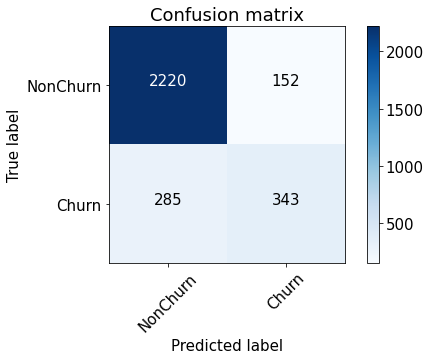

In [21]:
font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(7, 5))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.show()

In [22]:


params={'classifier__max_features':[0.3, 0.5, 0.7],
        'classifier__min_samples_leaf':[1, 2, 3],
        'classifier__max_depth':[None]
        }

In [23]:
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__max_depth': None,
 'classifier__max_features': 0.3,
 'classifier__min_samples_leaf': 2}

In [24]:
results = pd.DataFrame(columns = ['model', 'threshold', 'f_score', 'precision', 'recall', 'income'])

In [25]:
pipeline_RF = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=None, max_features=0.3, 
                                          min_samples_leaf=2, random_state=42)),
])
pipeline_RF.fit(X_train, y_train)
preds = pipeline_RF.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.339554, F-Score=0.630, Precision=0.678, Recall=0.588


Confusion matrix, without normalization
[[2197  175]
 [ 260  368]]


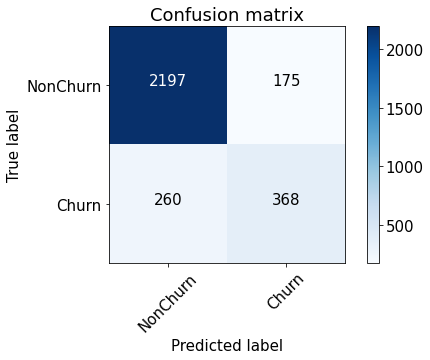

In [26]:
font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(7, 5))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [27]:
results = results.append({'model':'RandomForest',
                'threshold': thresholds[ix],
                'f_score': fscore[ix],
                'precision': precision[ix],
                'recall': recall[ix],
                'income': cnf_matrix[1][1] - cnf_matrix[0][1]},
               ignore_index=True)
results

,model,threshold,f_score,precision,recall,income
0,RandomForest,0.339554,0.629693,0.678309,0.58758,193


In [28]:
th, income = get_rubles(y_test, preds)
preds_cl = preds.copy()
preds_cl[preds_cl>th] = 1
preds_cl[preds_cl<th] = 0


Best income 227 at threshold: 0.495


In [29]:
results = results.append({'model':'RandomForest',
                'threshold': th,
                'f_score': f1_score(y_test, preds_cl),
                'precision': precision_score(y_test, preds_cl),
                'recall': recall_score(y_test, preds_cl),
                'income': income},
               ignore_index=True)
results

,model,threshold,f_score,precision,recall,income
0,RandomForest,0.339554,0.629693,0.678309,0.587580,193
1,RandomForest,0.495000,0.593718,0.816156,0.466561,227


In [30]:
# final_transformers = list()

# for cat_col in categorical_columns:
#     cat_transformer = Pipeline([
#                 ('selector', FeatureSelector(column=cat_col)),
#                 ('ohe', OHEEncoder(key=cat_col))
#             ])
#     final_transformers.append((cat_col, cat_transformer))
    
# for cont_col in binary_columns:
#     cont_transformer = Pipeline([
#                 ('selector', NumberSelector(key=cont_col))
#             ])
#     final_transformers.append((cont_col, cont_transformer))
    
# for cont_col in continuous_columns:
#     cont_transformer = Pipeline([
#                 ('selector', NumberSelector(key=cont_col)),
#                 ('standard', StandardScaler())
#             ])
#     final_transformers.append((cont_col, cont_transformer))

In [31]:
pipeline_GB = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

In [32]:
pipeline_GB.fit(X_train, y_train)


preds = pipeline_GB.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.307054, F-Score=0.641, Precision=0.666, Recall=0.618


Confusion matrix, without normalization
[[2177  195]
 [ 241  387]]


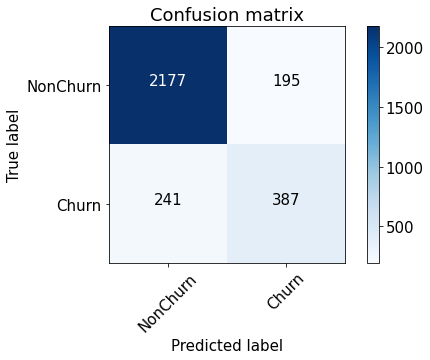

In [33]:
font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(7, 5))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [34]:
results = results.append({'model':'GradientBoosting',
                'threshold': thresholds[ix],
                'f_score': fscore[ix],
                'precision': precision[ix],
                'recall': recall[ix],
                'income': cnf_matrix[1][1] - cnf_matrix[0][1]},
               ignore_index=True)
results

,model,threshold,f_score,precision,recall,income
0,RandomForest,0.339554,0.629693,0.678309,0.587580,193
1,RandomForest,0.495000,0.593718,0.816156,0.466561,227
2,GradientBoosting,0.307054,0.640793,0.665523,0.617834,192


In [35]:
th, income = get_rubles(y_test, preds)
preds_cl = preds.copy()
preds_cl[preds_cl>th] = 1
preds_cl[preds_cl<th] = 0

Best income 230 at threshold: 0.465


In [36]:
results = results.append({'model':'GradientBoosting',
                'threshold': th,
                'f_score': f1_score(y_test, preds_cl),
                'precision': precision_score(y_test, preds_cl),
                'recall': recall_score(y_test, preds_cl),
                'income': income},
               ignore_index=True)
results

,model,threshold,f_score,precision,recall,income
0,RandomForest,0.339554,0.629693,0.678309,0.587580,193
1,RandomForest,0.495000,0.593718,0.816156,0.466561,227
2,GradientBoosting,0.307054,0.640793,0.665523,0.617834,192
3,GradientBoosting,0.465000,0.606719,0.799479,0.488854,230


In [37]:
pipeline_LR = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(C=1)),
])

pipeline_LR.fit(X_train, y_train)
preds = pipeline_LR.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
a = [el for el in fscore if el is not None]
# locate the index of the largest f score
ix = np.where(fscore == max(fscore))[0][0]
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))


Best Threshold=0.240695, F-Score=0.503, Precision=0.441, Recall=0.584


In [38]:
# fscore = fscore - fscore[fscore is None]
# a = [el for el in fscore if el is not None]
# a

In [39]:
# pred_cl = pipeline_LR.predict(X_test)

# f1_score(y_test, pred_cl)

Confusion matrix, without normalization
[[1907  465]
 [ 262  366]]


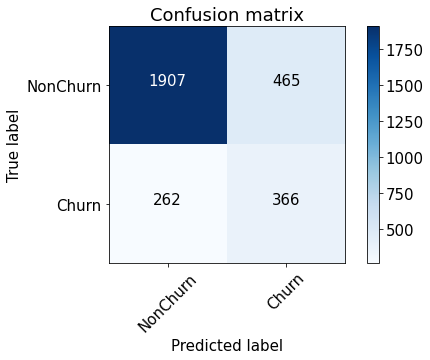

In [40]:
font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(7, 5))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [41]:
results = results.append({'model':'LogisticRegression',
                'threshold': thresholds[ix],
                'f_score': fscore[ix],
                'precision': precision[ix],
                'recall': recall[ix],
                'income': cnf_matrix[1][1] - cnf_matrix[0][1]},
               ignore_index=True)
results

,model,threshold,f_score,precision,recall,income
0,RandomForest,0.339554,0.629693,0.678309,0.587580,193
1,RandomForest,0.495000,0.593718,0.816156,0.466561,227
2,GradientBoosting,0.307054,0.640793,0.665523,0.617834,192
3,GradientBoosting,0.465000,0.606719,0.799479,0.488854,230
4,LogisticRegression,0.240695,0.502740,0.441106,0.584395,-99


In [42]:
# plt.scatter(thresholds[0:3000], precision[0:3000])
# plt.scatter(thresholds[0:3000], recall[0:3000])
# plt.show()

In [43]:
th, income = get_rubles(y_test, preds)
preds_cl = preds.copy()
preds_cl[preds_cl>th] = 1
preds_cl[preds_cl<th] = 0

Best income 57 at threshold: 0.535


In [44]:
results = results.append({'model':'LogisticRegression',
                'threshold': th,
                'f_score': f1_score(y_test, preds_cl),
                'precision': precision_score(y_test, preds_cl),
                'recall': recall_score(y_test, preds_cl),
                'income': income},
               ignore_index=True)
results

,model,threshold,f_score,precision,recall,income
0,RandomForest,0.339554,0.629693,0.678309,0.587580,193
1,RandomForest,0.495000,0.593718,0.816156,0.466561,227
2,GradientBoosting,0.307054,0.640793,0.665523,0.617834,192
3,GradientBoosting,0.465000,0.606719,0.799479,0.488854,230
4,LogisticRegression,0.240695,0.502740,0.441106,0.584395,-99
5,LogisticRegression,0.535000,0.285357,0.666667,0.181529,57
